In [24]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns

import librosa
import librosa.display
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import  to_categorical
from keras.callbacks import ModelCheckpoint


from IPython.display import Audio

from glob import glob
import warnings
warnings.filterwarnings("ignore")

from itertools import cycle

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [25]:
# from google.colab import drive
# drive.mount('/content/MyDrive')

In [26]:
audio_recs = glob('/home/sadgeu/projects/Speech Emotion Recognition/Data/AudioWAV/*.wav')
audio_recs

['/home/sadgeu/projects/Speech Emotion Recognition/Data/AudioWAV/1014_WSI_NEU_XX.wav',
 '/home/sadgeu/projects/Speech Emotion Recognition/Data/AudioWAV/1025_IEO_SAD_HI.wav',
 '/home/sadgeu/projects/Speech Emotion Recognition/Data/AudioWAV/1016_IWW_ANG_XX.wav',
 '/home/sadgeu/projects/Speech Emotion Recognition/Data/AudioWAV/1025_DFA_HAP_XX.wav',
 '/home/sadgeu/projects/Speech Emotion Recognition/Data/AudioWAV/1001_IEO_NEU_XX.wav',
 '/home/sadgeu/projects/Speech Emotion Recognition/Data/AudioWAV/1035_DFA_HAP_XX.wav',
 '/home/sadgeu/projects/Speech Emotion Recognition/Data/AudioWAV/1016_TSI_SAD_XX.wav',
 '/home/sadgeu/projects/Speech Emotion Recognition/Data/AudioWAV/1015_IWL_SAD_XX.wav',
 '/home/sadgeu/projects/Speech Emotion Recognition/Data/AudioWAV/1037_IWW_SAD_XX.wav',
 '/home/sadgeu/projects/Speech Emotion Recognition/Data/AudioWAV/1017_IOM_NEU_XX.wav',
 '/home/sadgeu/projects/Speech Emotion Recognition/Data/AudioWAV/1033_IWW_ANG_XX.wav',
 '/home/sadgeu/projects/Speech Emotion Reco

In [27]:
Audio(audio_recs[0])

In [28]:
y, sr = librosa.load(audio_recs[0])

<Axes: >

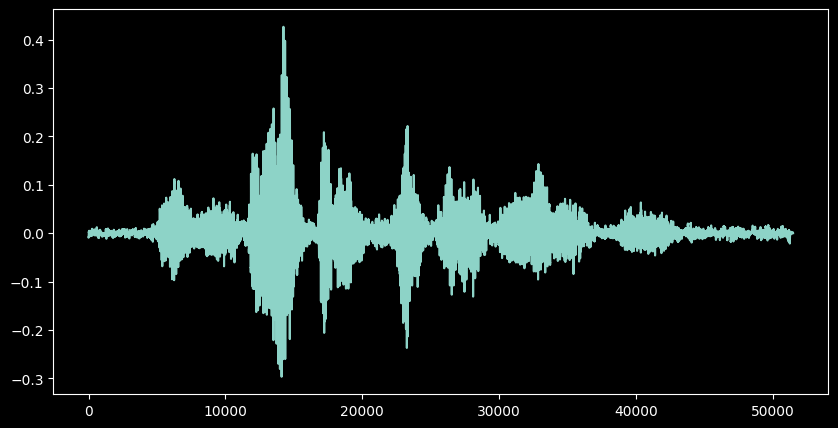

In [29]:
pd.Series(y).plot(figsize=(10, 5))

In [30]:
!pip install noisereduce

In [31]:
from scipy.io import wavfile
import noisereduce as nr
import numpy as np

# Ensure that temp_rec is a path to a valid audio file
temp_rec = audio_recs[0]

# Read the audio file
rate, data = wavfile.read(temp_rec)

# If the audio is stereo (2 channels), convert it to mono
if len(data.shape) == 2:  # Check if it's stereo
    data = np.mean(data, axis=1)  # Convert to mono by averaging the channels

# Apply noise reduction
reduced_noise = nr.reduce_noise(y=data, sr=rate)

# Write the output to a new file
wavfile.write("filtered_temp_rec.wav", rate, reduced_noise.astype(np.int16))


In [32]:
Audio("filtered_temp_rec.wav")

<Axes: >

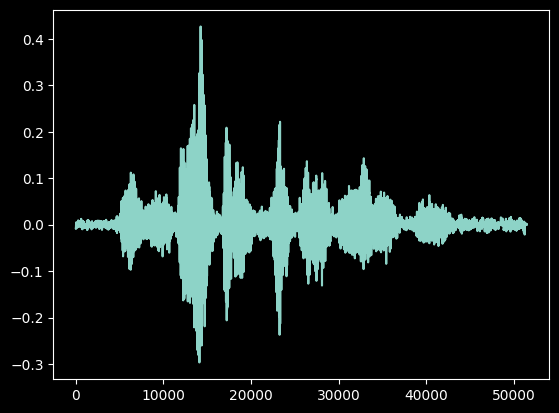

In [33]:
y, sr = librosa.load(temp_rec)
pd.Series(y).plot()

In [34]:
from functools import partial
CREMA = '/home/sadgeu/projects/Speech Emotion Recognition/Data/AudioWAV/'
crema_directory = os.listdir(CREMA)

file_emotion = []
file_path = []

for file in crema_directory:
    # storing file paths
    file_path.append(CREMA + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('unknown')

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
crema_df = pd.concat([emotion_df, path_df], axis=1)
crema_df.head()

,Emotions,Path
0,neutral,/home/sadgeu/projects/Speech Emotion Recogniti...
1,sad,/home/sadgeu/projects/Speech Emotion Recogniti...
2,angry,/home/sadgeu/projects/Speech Emotion Recogniti...
3,happy,/home/sadgeu/projects/Speech Emotion Recogniti...
4,neutral,/home/sadgeu/projects/Speech Emotion Recogniti...


In [35]:
crema_df.to_csv("crema_df.csv", index=False)
crema_df

,Emotions,Path
0,neutral,/home/sadgeu/projects/Speech Emotion Recogniti...
1,sad,/home/sadgeu/projects/Speech Emotion Recogniti...
2,angry,/home/sadgeu/projects/Speech Emotion Recogniti...
3,happy,/home/sadgeu/projects/Speech Emotion Recogniti...
4,neutral,/home/sadgeu/projects/Speech Emotion Recogniti...
...,...,...
2995,happy,/home/sadgeu/projects/Speech Emotion Recogniti...
2996,fear,/home/sadgeu/projects/Speech Emotion Recogniti...
2997,happy,/home/sadgeu/projects/Speech Emotion Recogniti...
2998,happy,/home/sadgeu/projects/Speech Emotion Recogniti...


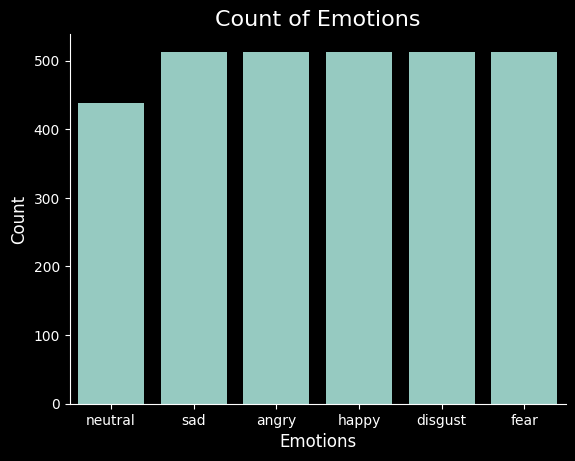

In [36]:
plt.title('Count of Emotions', size=16)
sns.countplot(x=crema_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [37]:
path = np.array(crema_df.Path[crema_df.Emotions == 'angry'])[9]
path

'/home/sadgeu/projects/Speech Emotion Recognition/Data/AudioWAV/1032_TIE_ANG_XX.wav'

Defining function to display waveplot etc.


In [38]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

In [39]:
def create_spectrogram(data, sr, e):
  X = librosa.stft(data)
  Xdb = librosa.amplitude_to_db(abs(X))
  plt.figure(figsize=(12, 3))
  plt.title(f'Spectrogram for audio with {e} emotion', size=15)
  librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
  plt.colorbar()

In [40]:
emotion = 'sad'
path = np.array(crema_df.Path[crema_df.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
Audio(path)

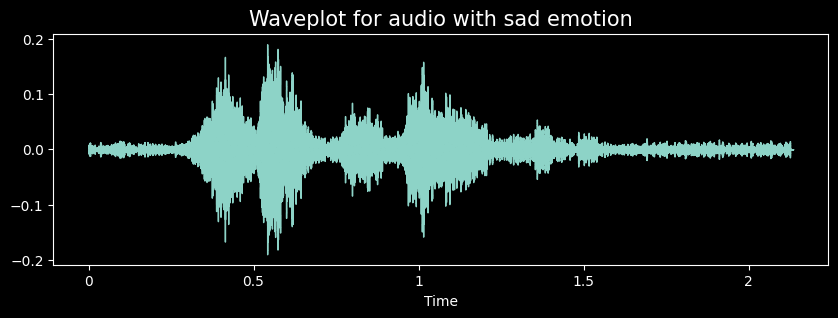

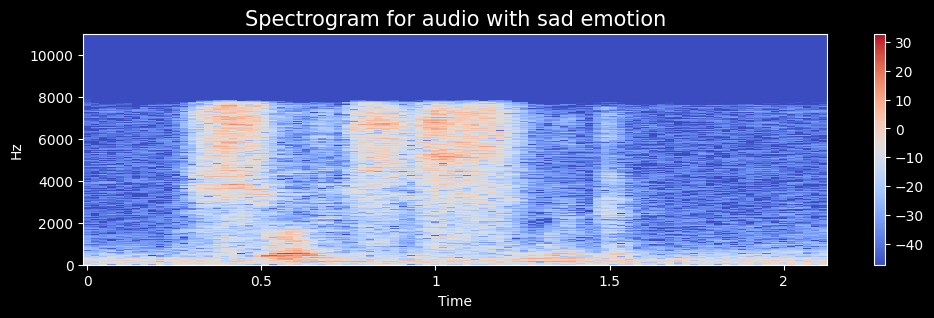

In [41]:
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

In [42]:
emotion = 'angry'
path = np.array(crema_df.Path[crema_df.Emotions == emotion])[9]
data, sampling_rate = librosa.load(path)
Audio(path)

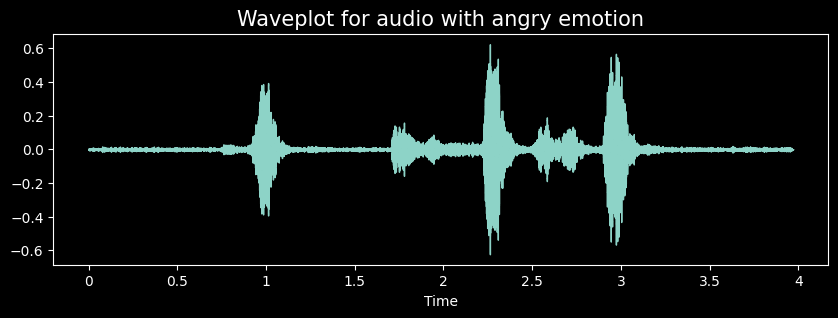

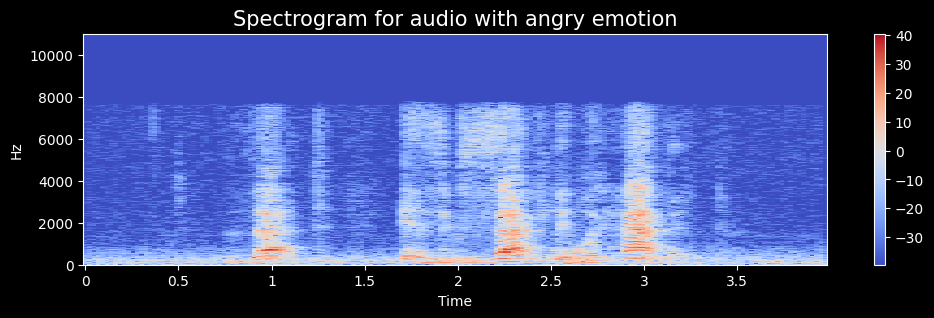

In [43]:
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

In [44]:
def waveplot(data,sr,emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion,size=20)
    librosa.display.waveshow(data,sr=sr)
    plt.show()
    
def spectogram(dat,sr,emotion):
    x=librosa.stft(data)
    xdb=librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(10,4))
    plt.title(emotion,size=20)
    librosa.display.specshow(xdb,sr=sr,x_axis="time",y_axis='hz')
    plt.colorbar()

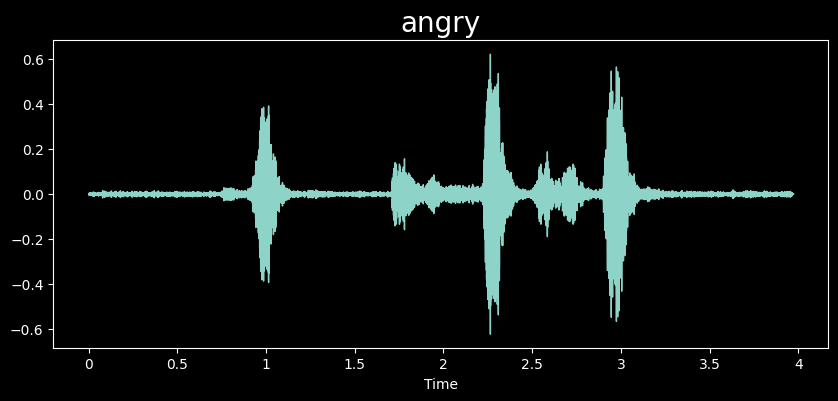

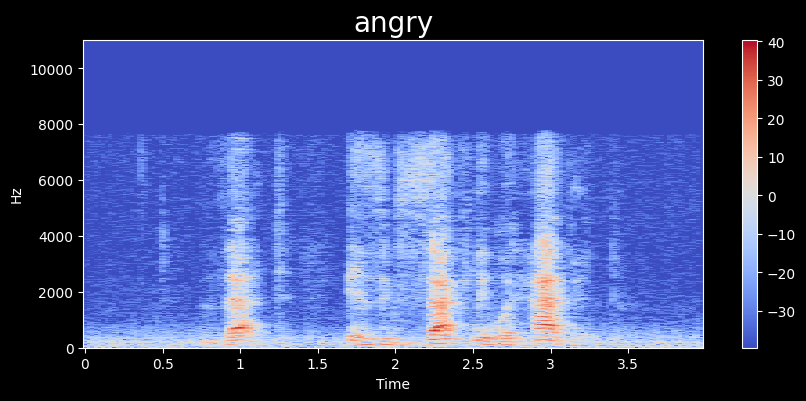

In [45]:
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)

In [46]:
emotion = 'neutral'
path = np.array(crema_df.Path[crema_df.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
Audio(path)

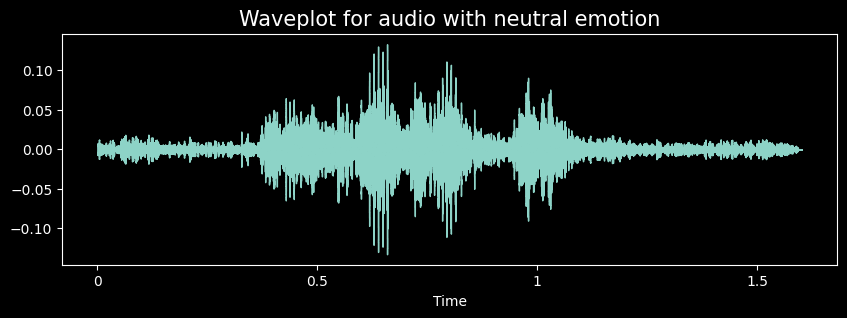

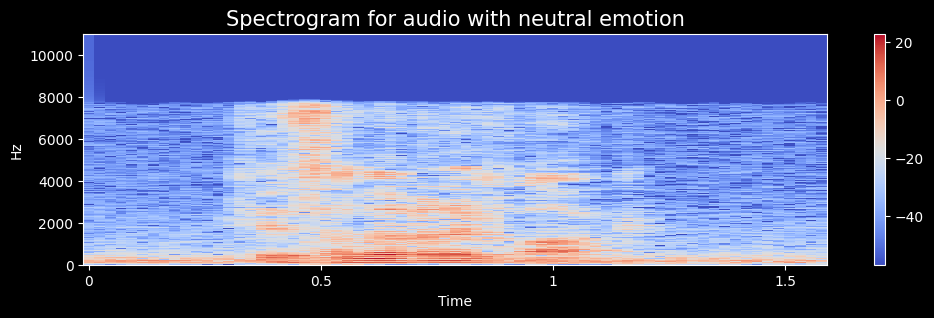

In [47]:
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

In [48]:
emotion = 'happy'
path = np.array(crema_df.Path[crema_df.Emotions == emotion])[9]
data, sampling_rate = librosa.load(path)
Audio(path)

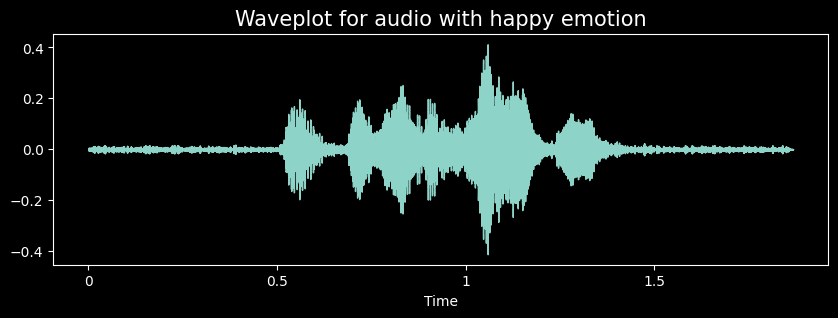

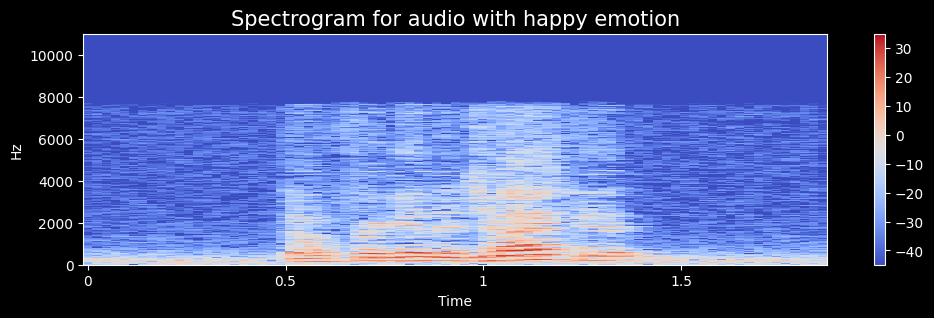

In [49]:
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

In [50]:
emotion = 'disgust'
path = np.array(crema_df.Path[crema_df.Emotions == emotion])[0]
data, sampling_rate = librosa.load(path)
Audio(path)

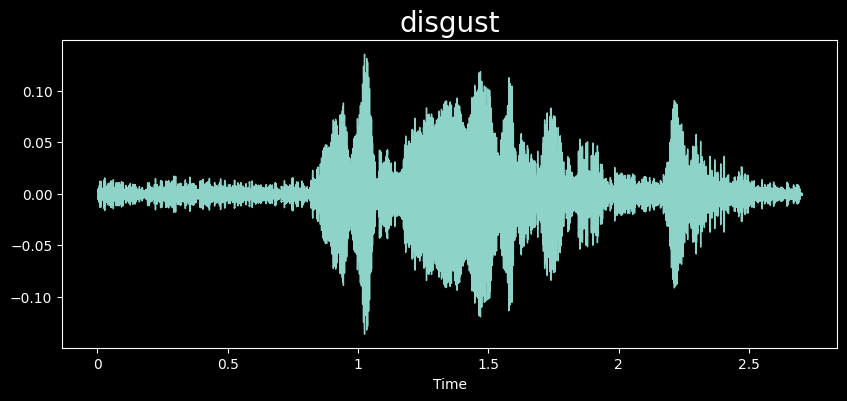

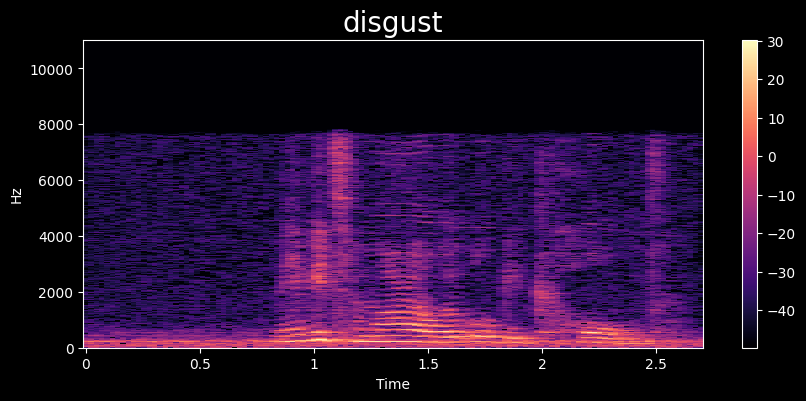

In [51]:
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)

In [52]:
emotion = 'fear'
path = np.array(crema_df.Path[crema_df.Emotions == emotion])[9]
data, sampling_rate = librosa.load(path)
Audio(path)

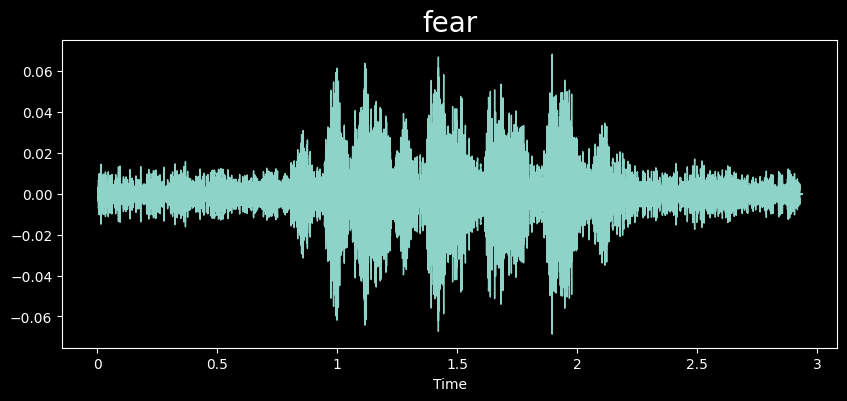

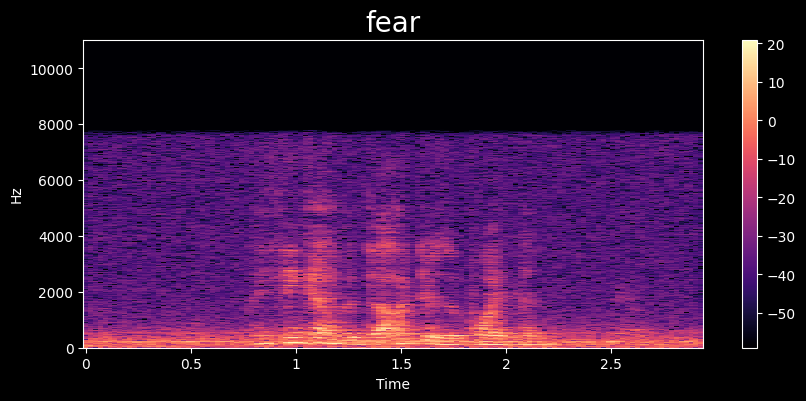

In [53]:
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)

In [54]:
import librosa.feature


def extract_mfcc(file_name):
    y, sampling_rate = librosa.load(file_name, duration=3, offset=0.5)

    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sampling_rate, n_mfcc=40).T,axis=0)

    return mfcc

In [55]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(crema_df.Path[crema_df.Emotions == emotion])[9]
data, sample_rate = librosa.load(path)

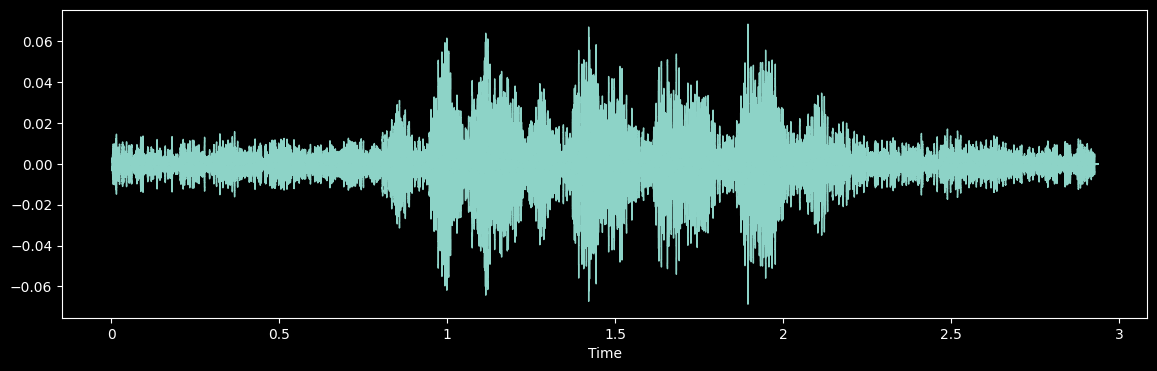

In [56]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

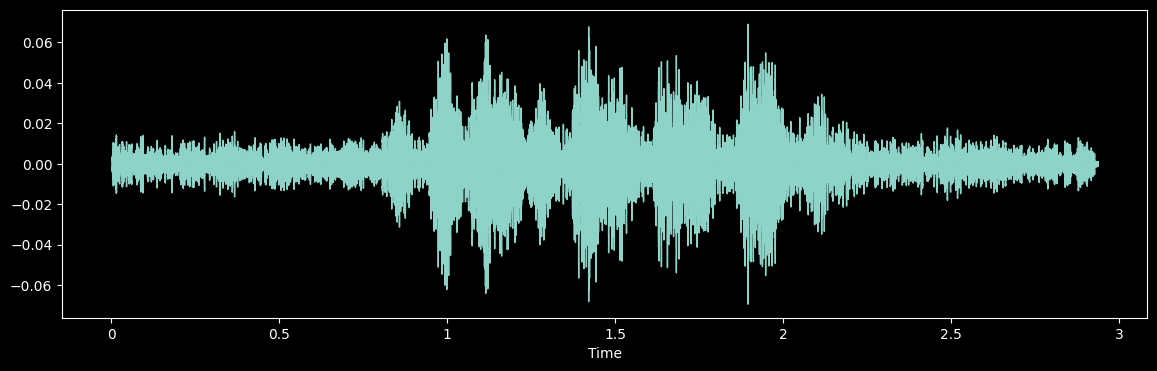

In [57]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [58]:
import soundfile as sf

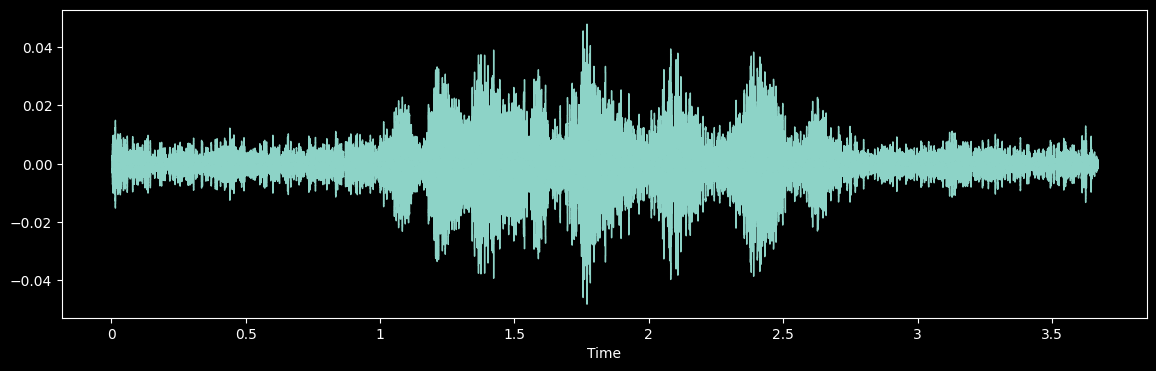

In [59]:
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

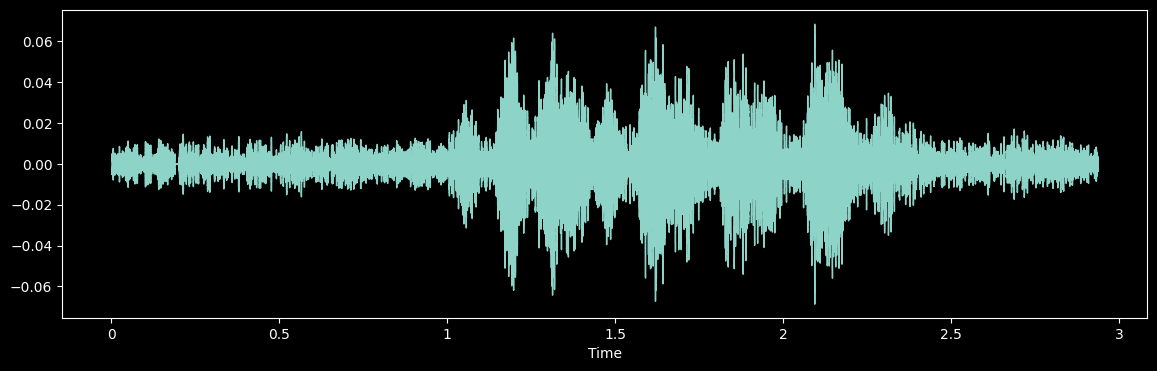

In [60]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

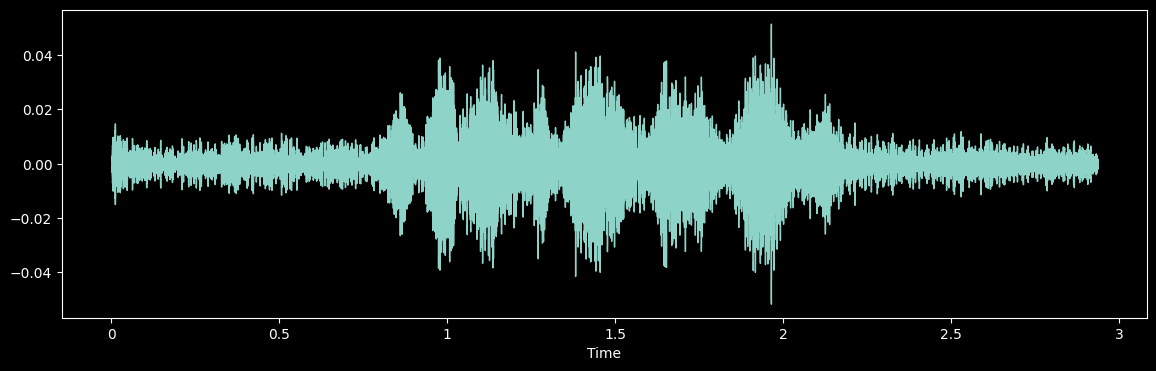

In [61]:
def pitch(data, sr, n_steps):
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=n_steps)

x = pitch(data, sample_rate, n_steps=4)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [62]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate, n_steps=4)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result


In [63]:
crema_df['Path'] = crema_df['Path'].apply(lambda x: x.split(':')[0])

In [64]:
file_path = '/home/pancake/projects/data/AudioWAV/1005_TAI_FEA_XX.wav'


In [65]:
X, Y = [], []
for path, emotion in zip(crema_df.Path, crema_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [66]:
len(X), len(Y), crema_df.Path.shape

(9000, 9000, (3000,))

In [67]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.096680,0.594692,0.651713,0.602604,0.607214,0.667580,0.595341,0.508523,0.479534,0.535702,...,1.458798e-06,1.339358e-06,1.255300e-06,1.192976e-06,1.146613e-06,1.113109e-06,1.088719e-06,1.072798e-06,1.062969e-06,neutral
1,0.208138,0.695646,0.753568,0.725372,0.738841,0.783656,0.673853,0.572442,0.540418,0.590092,...,2.739750e-03,2.691996e-03,2.688160e-03,2.562021e-03,2.600943e-03,2.640510e-03,2.831931e-03,2.615796e-03,2.518479e-03,neutral
2,0.131888,0.574332,0.675898,0.569805,0.565116,0.669138,0.581707,0.577942,0.654404,0.585997,...,6.702185e-04,2.719632e-04,3.951939e-04,3.734548e-04,7.707086e-05,2.258624e-06,7.630821e-07,4.508211e-07,1.046608e-07,neutral
3,0.041364,0.606277,0.670098,0.674441,0.668270,0.735395,0.723829,0.640415,0.665084,0.755577,...,8.211352e-11,7.769808e-11,7.439041e-11,7.178705e-11,6.976694e-11,6.826970e-11,6.714798e-11,6.640601e-11,6.593667e-11,sad
4,0.041337,0.609217,0.673306,0.677778,0.671450,0.738406,0.726127,0.640270,0.664526,0.755122,...,1.504726e-07,1.558249e-07,1.476384e-07,1.498473e-07,1.521516e-07,1.636730e-07,1.553268e-07,1.447778e-07,1.531831e-07,sad


In [68]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [69]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [70]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6750, 162), (6750, 6), (2250, 162), (2250, 6))

In [71]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6750, 162), (6750, 6), (2250, 162), (2250, 6))

In [72]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6750, 162, 1), (6750, 6), (2250, 162, 1), (2250, 6))

In [73]:
model = Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1],1)))
model.add(MaxPooling1D(pool_size=5, strides=1, padding='same'))
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=1, padding='same'))
model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=1, padding='same'))
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=1, padding='same'))
model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=6, activation='softmax'))
model.compile(optimizer = 'adam', loss= 'categorical_crossentropy', metrics=['accuracy'])

model.summary()

I0000 00:00:1735632089.213611   50754 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 162, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 162, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 162, 256)       │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 162, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 162, 128)       │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 162, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 162, 64)        │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 162, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       331,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 866,470 (3.31 MB)

 Trainable params: 866,470 (3.31 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [75]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50


I0000 00:00:1735632094.233901   56775 service.cc:148] XLA service 0x7f8748014d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735632094.235287   56775 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-12-31 15:01:34.368633: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735632094.820784   56775 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/106 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.1641 - loss: 1.8240 

I0000 00:00:1735632100.113144   56775 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


106/106 ━━━━━━━━━━━━━━━━━━━━ 19s 101ms/step - accuracy: 0.2565 - loss: 1.6927 - val_accuracy: 0.3289 - val_loss: 1.5759 - learning_rate: 0.0010
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.3288 - loss: 1.6017 - val_accuracy: 0.3431 - val_loss: 1.5410 - learning_rate: 0.0010
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.3397 - loss: 1.5750 - val_accuracy: 0.3564 - val_loss: 1.5209 - learning_rate: 0.0010
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.3491 - loss: 1.5444 - val_accuracy: 0.3711 - val_loss: 1.5210 - learning_rate: 0.0010
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.3581 - loss: 1.5246 - val_accuracy: 0.3667 - val_loss: 1.4859 - learning_rate: 0.0010
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.3706 - loss: 1.5020 - val_accuracy: 0.3956 - val_loss: 1.4746 - learning_rate: 0.0010
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.3698 - loss: 1.4916 - va

71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4615 - loss: 1.5937
Accuracy of our model on test data :  46.666666865348816 %


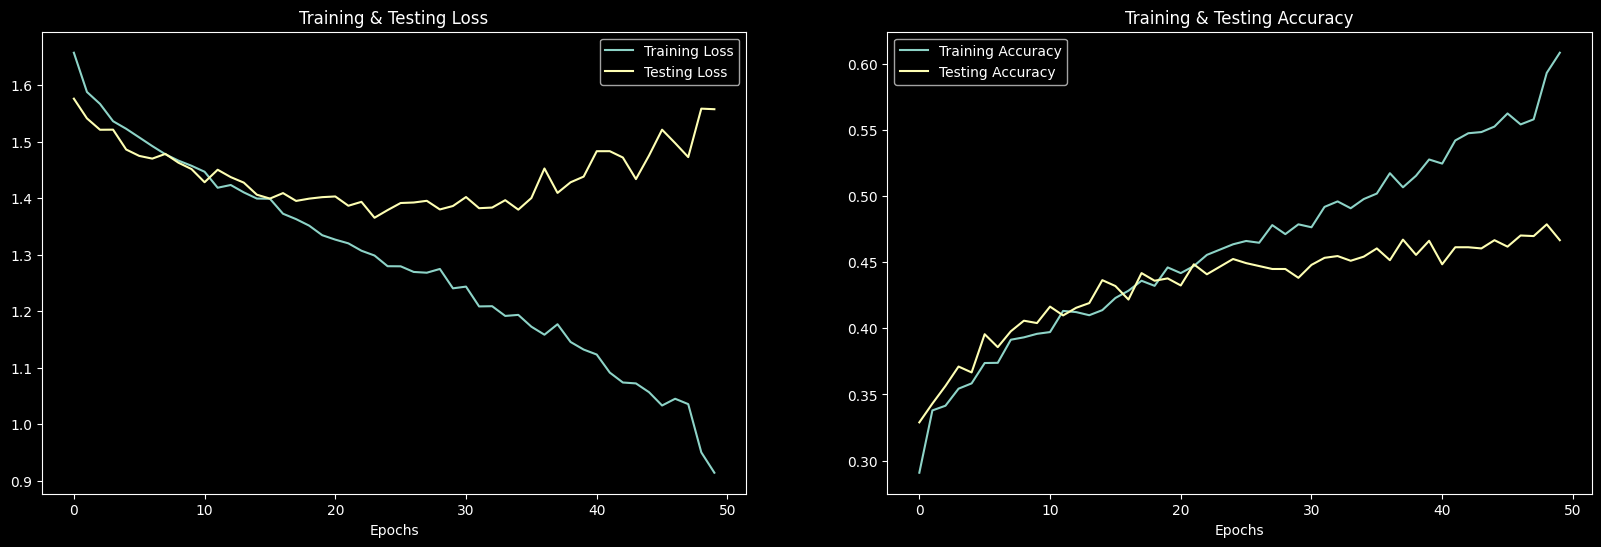

In [77]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [78]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [79]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,happy,happy
1,angry,angry
2,neutral,angry
3,neutral,fear
4,angry,disgust
5,sad,sad
6,sad,neutral
7,disgust,fear
8,fear,happy
9,sad,sad


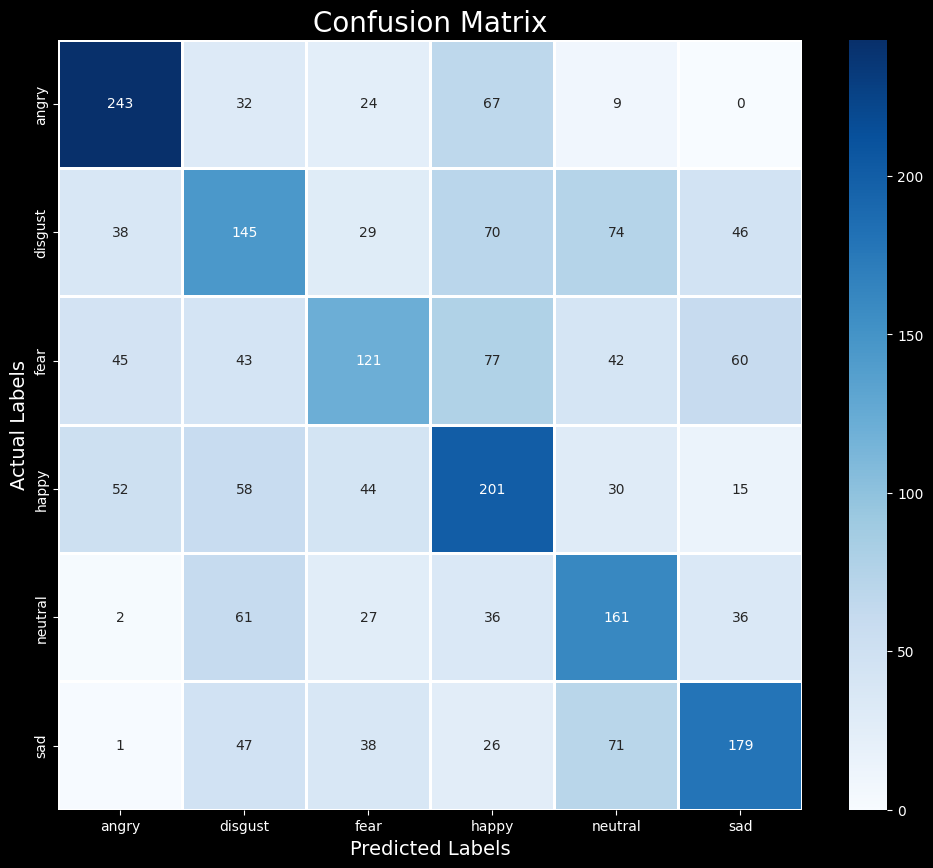

In [80]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [81]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.64      0.65      0.64       375
     disgust       0.38      0.36      0.37       402
        fear       0.43      0.31      0.36       388
       happy       0.42      0.50      0.46       400
     neutral       0.42      0.50      0.45       323
         sad       0.53      0.49      0.51       362

    accuracy                           0.47      2250
   macro avg       0.47      0.47      0.47      2250
weighted avg       0.47      0.47      0.46      2250



In [5]:
!pip install vggish


ERROR: Could not find a version that satisfies the requirement vggish (from versions: none)
ERROR: No matching distribution found for vggish


In [4]:
from vggish import VGGish
from vggish_input import wavfile_to_examples

# Load pre-trained VGGish model
vggish = VGGish()


ModuleNotFoundError: No module named 'vggish'